<a href="https://colab.research.google.com/github/tokarchyn/diabetic-retinopathy-thesis/blob/master/diabetic-retinopathy-ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import sys
from IPython.display import display, clear_output
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
pd.options.mode.chained_assignment = None

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8112204411125791153
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1902469845679446331
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8517297024297481595
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15777306681288137855
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
base_image_dir = os.path.join('drive/My Drive/Colab Notebooks', 'kaggle_data', 'train')
retina_df = pd.read_csv(os.path.join('drive/My Drive/Colab Notebooks', 'kaggle_data', 'trainLabels.csv'))
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

8407 images found of 35126 total


Using TensorFlow backend.


,image,level,PatientId,path,exists,eye,level_cat
11999,15043_right,0,15043,drive/My Drive/Colab Notebooks/kaggle_data/tra...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
10660,13420_left,2,13420,drive/My Drive/Colab Notebooks/kaggle_data/tra...,True,1,"[0.0, 0.0, 1.0, 0.0, 0.0]"
10143,12775_right,2,12775,drive/My Drive/Colab Notebooks/kaggle_data/tra...,True,0,"[0.0, 0.0, 1.0, 0.0, 0.0]"


In [0]:
retina_df['level'].value_counts().plot(kind='bar', figsize=(14,8), title='Level distribution')

## Split Data into Training and Validation

In [9]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
rr_df = rr_df.sample(1000)
train_ids, val_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.20, 
                                   random_state = 2020)
train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
val_df = retina_df[retina_df['PatientId'].isin(val_ids)]
print('train', train_df.shape[0], 'val', val_df.shape[0])

train 1564 val 397


In [0]:
def get_label(file_path):
  return 

### Creating Tensorflow Dataset

In [0]:
CLASS_NAMES = np.array(['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR'])
WIDTH, HEIGHT = 128, 128
BATCH_SIZE = 64

In [0]:
def createDataGen(df):
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
          rescale=1./255,
          horizontal_flip=True)
  df['level'] = df['level'].astype(str)
  return datagen.flow_from_dataframe(df, x_col='path', y_col='level', target_size=(WIDTH,HEIGHT), 
                                     batch_size=BATCH_SIZE)
  
train_gen = createDataGen(train_df)
test_gen = createDataGen(test_df)

Found 679 validated image filenames belonging to 5 classes.
Found 242 validated image filenames belonging to 5 classes.


In [0]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(5):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')        

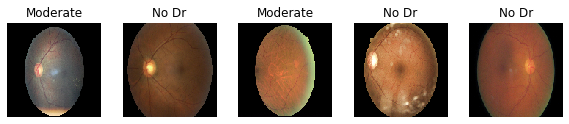

In [0]:
image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='softmax', padding='same',input_shape=(HEIGHT, WIDTH, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='softmax',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='softmax',padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='softmax'))
model.add(layers.Dense(len(CLASS_NAMES), activation='softmax'))
model.summary()
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________

In [0]:
model.fit_generator(train_gen, steps_per_epoch=train_df.shape[0] // BATCH_SIZE, epochs=2,
          validation_data=test_gen, validation_steps=test_df.shape[0] // BATCH_SIZE)

Epoch 1/2
10/10 [==============================] - 103s 10s/step - loss: 1.5628 - acc: 0.6390 - val_loss: 1.5141 - val_acc: 0.7500
Epoch 2/2
10/10 [==============================] - 104s 10s/step - loss: 1.5025 - acc: 0.7171 - val_loss: 1.4819 - val_acc: 0.7500


In [0]:
model.predict_classes(image_batch)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
label_batch

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1.